### Mandelbrot Set Visualisation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import pchip_interpolate
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import qmc
import statistics
import time
import pandas as pd
import scipy.optimize as opt


In [3]:
def mandelbrot(c, z):
    return z**2 + c

def stability(c, max_iter):
    z = 0
    for i in range(max_iter):
        z = mandelbrot(c, z)
        if abs(z) > 2:
            return i
    return max_iter

def mandelbrot_set(width, height, real_range, imag_range, max_iter = 200):
    real_vals = np.linspace(real_range[0], real_range[1], width)
    imag_vals = np.linspace(imag_range[0], imag_range[1], height)
    
    image = np.empty((width, height))
    for i in range(width):
        for j in range(height):
            image[i, j] = stability(real_vals[i] + 1j*imag_vals[j], max_iter)
    return image
    

In [4]:
# Compute the Mandelbrot set
resolution = 1000
max_iter = 200
width = resolution
height = resolution
real_range = [-2, 1]
imag_range = [-1.5, 1.5]
image = mandelbrot_set(width, height, real_range, imag_range, max_iter=max_iter)

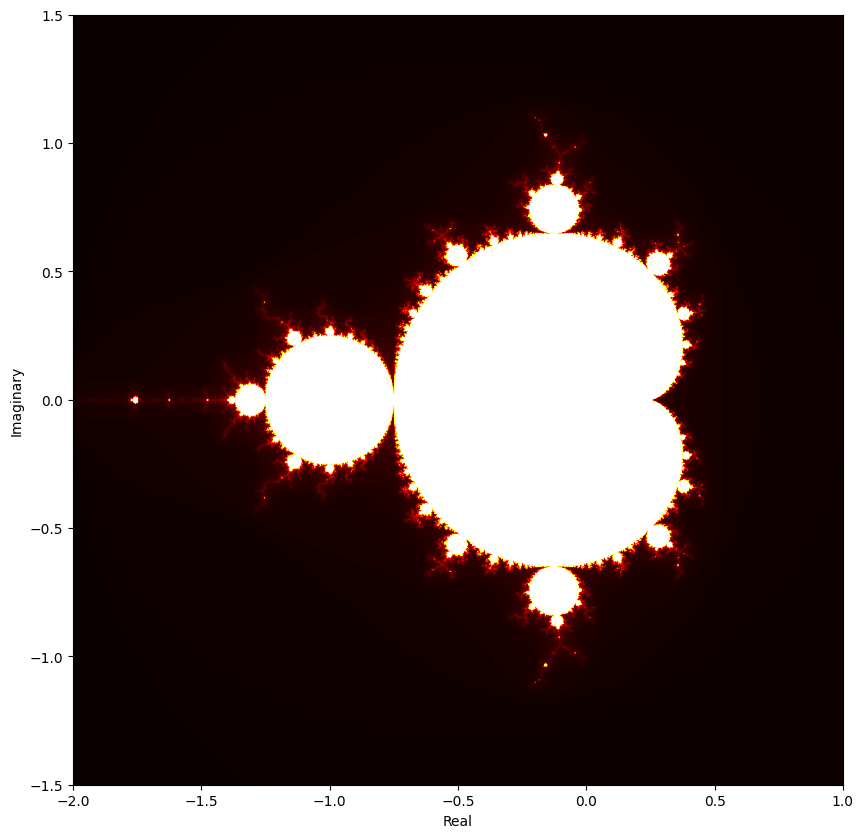

In [5]:
# Visualize with interpolation
plt.figure(figsize=(10, 10))
plt.imshow(image.T, cmap='hot', interpolation='bilinear', extent=[-2, 1, -1.5, 1.5])
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.show()

In [6]:
def custom_colourmap():
    #set up the control points for your gradient
    yR_observed = [0, 0,32,237, 255, 155, 0, 32]
    yG_observed = [2, 7, 107, 255, 170, 120, 7, 107]
    yB_observed = [0, 100, 203, 255, 0, 0, 100, 203]

    x_observed = [-.1425, 0, .16, .42, .6425, .8575, 1, 1.16]

    #Create the arrays with the interpolated values
    x = np.linspace(min(x_observed), max(x_observed), num=1000)
    yR = pchip_interpolate(x_observed, yR_observed, x)
    yG = pchip_interpolate(x_observed, yG_observed, x)
    yB = pchip_interpolate(x_observed, yB_observed, x)

    #Convert them back to python lists
    x = list(x)
    yR = list(yR)
    yG = list(yG)
    yB = list(yB)

    #Find the indexs where x crosses 0 and crosses 1 for slicing
    start = 0
    end = 0
    for i in x:
        if i > 0:
            start = x.index(i)
            break

    for i in x:
        if i > 1:
            end = x.index(i)
            break

    #Slice away the helper data in the begining and end leaving just 0 to 1
    x = x[start:end]
    yR = yR[start:end]
    yG = yG[start:end]
    yB = yB[start:end]

    # Normalize the color values to the [0, 1] range
    yR = np.array(yR) / 255.0
    yG = np.array(yG) / 255.0
    yB = np.array(yB) / 255.0

    # Append 0 to the end of yR, yG, and yB
    yR = np.append(yR, 0.0)
    yG = np.append(yG, 0.0)
    yB = np.append(yB, 0.0)

    # Create a custom colormap from the interpolated color values
    colors = np.column_stack((yR, yG, yB))  # Combine R, G, and B values
    cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)
    
    return cmap


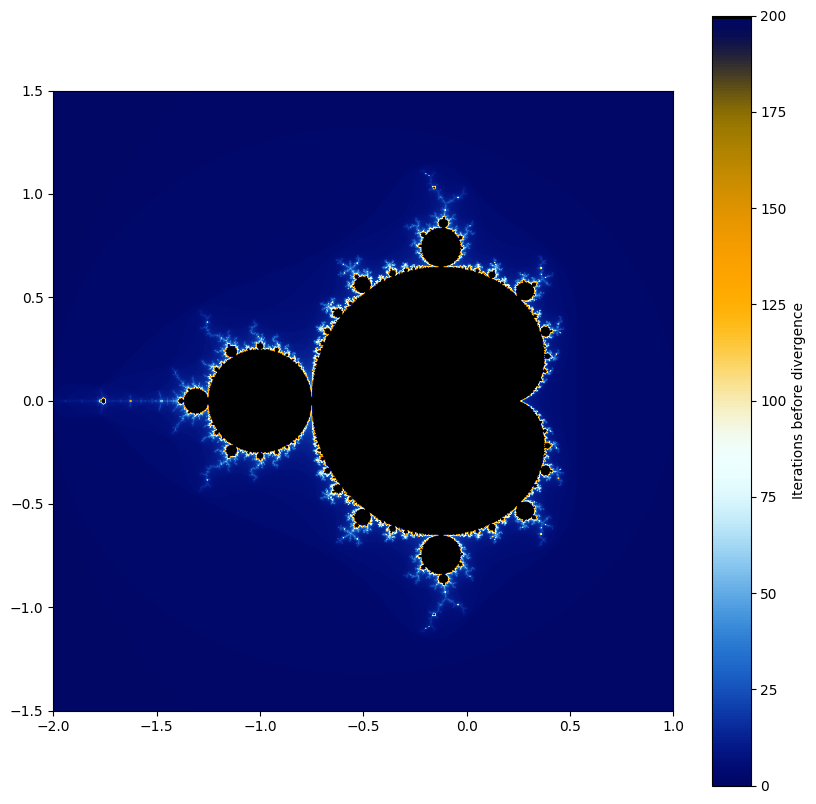

In [7]:
cmap = custom_colourmap()

# Create a figure and plot the data using the custom colormap
plt.figure(figsize=(10, 10))
plt.imshow(image.T, cmap=cmap, extent=[-2, 1, -1.5, 1.5])
plt.colorbar().set_label('Iterations before divergence')
plt.show()

In [8]:
# Seahorse valley
resolution = 1000
max_iter = 200
width = resolution
height = resolution
real_range = [-0.75, -0.74]
imag_range = [0.1, 0.11]
seahorse_valley = mandelbrot_set(width, height, real_range, imag_range, max_iter=max_iter)

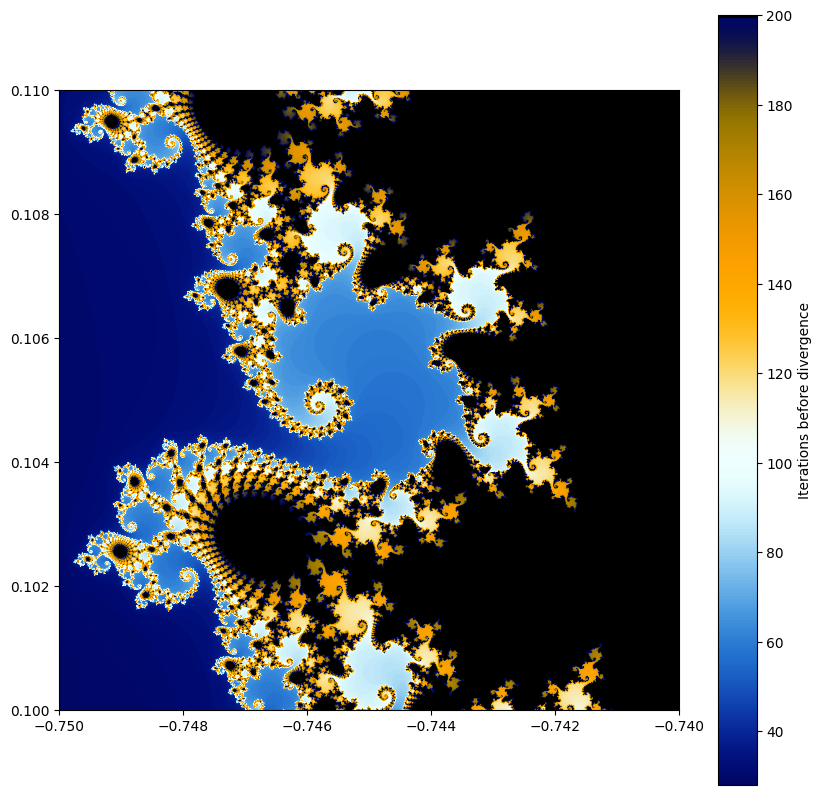

In [9]:
# Plot seahorse valley
plt.figure(figsize=(10, 10))
plt.imshow(seahorse_valley.T, cmap=cmap, extent=[-0.75, -0.74, 0.1, 0.11])
plt.colorbar().set_label('Iterations before divergence')
plt.show()

### Mandelbrot Set Computation

In [10]:
def random_sampling(s, x_range = [-2, 1], y_range = [-1.5, 1.5]):
    x_samples = np.random.uniform(low=x_range[0], high=x_range[1], size=s)
    y_samples = np.random.uniform(low=y_range[0], high=y_range[1], size=s)
    samples = np.column_stack((x_samples, y_samples))
    return samples

def additional_random_sampling(current_samples, s, x_range = [-2, 1], y_range = [-1.5, 1.5]):
    # Initial sample was probably done with seed 4444, so new part shouldnt be the same!
    new_sample = random_sampling(s - len(current_samples), x_range, y_range)
    samples = np.concatenate((current_samples, new_sample), axis=0)
    return samples

def latin_hypercube_sampling(s, x_range = [-2, 1], y_range = [-1.5, 1.5], strength = 1, numpy_random_generator = np.random.Generator(np.random.PCG64())):
    sampler = qmc.LatinHypercube(d=2, strength=strength, seed=numpy_random_generator)
    sample = sampler.random(n=s)
    l_bounds = np.array([x_range[0], y_range[0]])
    u_bounds = np.array([x_range[1], y_range[1]])
    sample = qmc.scale(sample, l_bounds, u_bounds)
    return sample

def orthogonal_sampling(s, x_range = [-2, 1], y_range = [-1.5, 1.5], numpy_random_generator = np.random.Generator(np.random.PCG64())):
    return latin_hypercube_sampling(s, x_range, y_range, strength = 2, numpy_random_generator=numpy_random_generator)

def approximation(samples, i, visualize_sample = False, x_range = [-2, 1], y_range = [-1.5, 1.5]):
    # Approximate the area of the mandelbrot set. samples is a list of samples, i is the number of iterations for the mandelbrot calculation
    
    # Compute the area of the mandelbrot set
    area = 0
    for sample in samples:
        if stability(sample[0] + 1j*sample[1], max_iter=i) == i:
            area += 1

    #plot samples to visualize
    if visualize_sample:
        in_area = []
        out_area = []
        for sample in samples:
            if stability(sample[0] + 1j*sample[1], max_iter=max_iter) == max_iter:
                in_area.append(sample)
            else:
                out_area.append(sample)

        # Plot the sample over our mandelbrot set
        plt.figure(figsize=(10, 10))
        plt.imshow(image.T, cmap=cmap, interpolation='bilinear', extent=[-2, 1, -1.5, 1.5])
        # plt.scatter(samples[:, 0], samples[:, 1], color='red', s=0.6)
        # in_area green, out_area red
        plt.scatter(np.array(in_area)[:, 0], np.array(in_area)[:, 1], color='green', s=0.6)
        plt.scatter(np.array(out_area)[:, 0], np.array(out_area)[:, 1], color='red', s=0.6)
        plt.show()
    
    
    # Scale the area to the size of the mandelbrot set
    area = area / len(samples) * (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])
    
    return area

In [11]:
# Test if the numpy random generator works
generator = np.random.Generator(np.random.PCG64(seed=4444))

print(latin_hypercube_sampling(4, numpy_random_generator=generator))

generator = np.random.Generator(np.random.PCG64(seed=4444))

print(latin_hypercube_sampling(4, numpy_random_generator=generator))

print(latin_hypercube_sampling(4, numpy_random_generator=generator))


[[ 0.25705496 -0.55226063]
 [-1.50133642  1.22169109]
 [-0.01522048 -1.38626516]
 [-0.65565678  0.49768446]]
[[ 0.25705496 -0.55226063]
 [-1.50133642  1.22169109]
 [-0.01522048 -1.38626516]
 [-0.65565678  0.49768446]]
[[ 0.47673915 -0.54965559]
 [-1.74812439  0.5379105 ]
 [ 0.14053589 -0.99450401]
 [-0.85299634  0.86692645]]


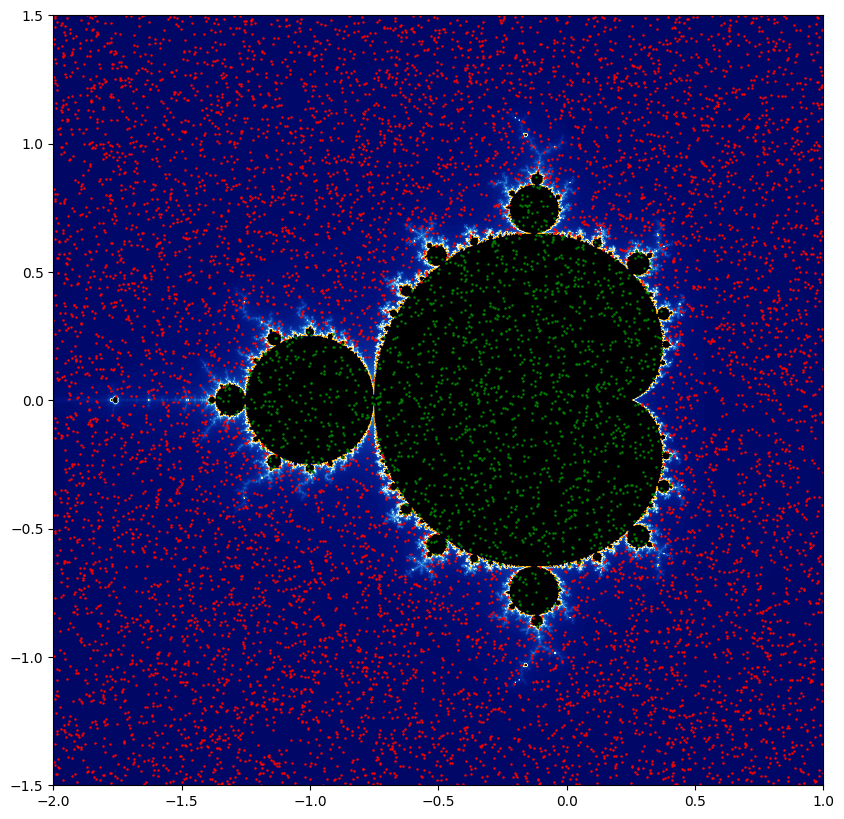

Area using random_sampling: 1.4910302911479265


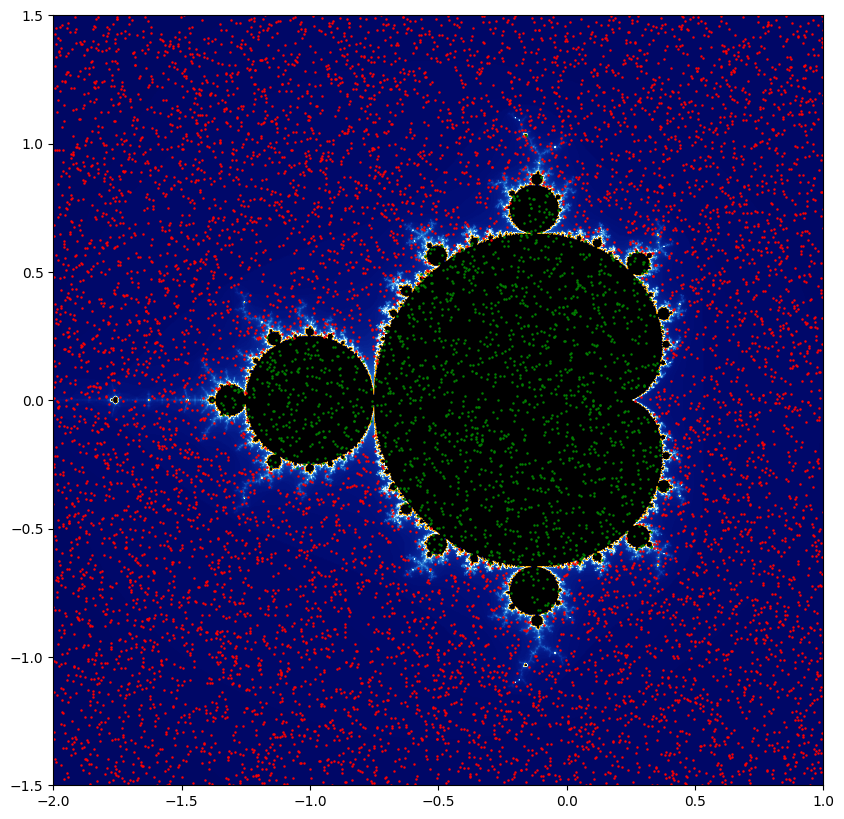

Area using latin_hypercube_sampling: 1.5192628173708462


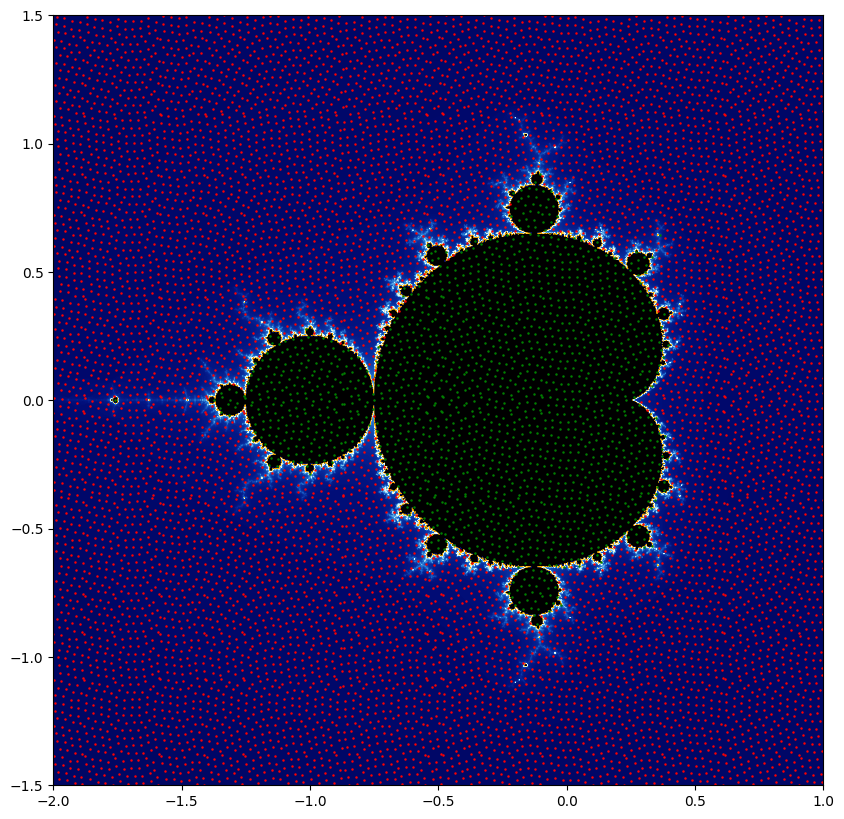

Area using orthogonal_sampling: 1.5148514851485149


In [13]:
visualize = True
for sampling_method in [random_sampling, latin_hypercube_sampling, orthogonal_sampling]:
    sample = sampling_method(101**2)
    area = approximation(sample, 2000, visualize_sample = visualize)
    print(f'Area using {sampling_method.__name__}: {area}')

In [26]:
Am = []
s = 1009**2
i = 10000
for sampling_method in [random_sampling, latin_hypercube_sampling, orthogonal_sampling]:
    start = time.time()
    sample = sampling_method(s)
    sampling_time = time.time() - start
    area = approximation(sample, i)
    approximation_time = time.time() - start - sampling_time
    print(f"Area for {s} samples and {i} iterations: {area} (sampling time: {round(sampling_time, 2)}s, approximation time: {round(approximation_time, 2)}s)")
    Am.append(area)

Area for 1018081 samples and 10000 iterations: 1.5108277239237349 (sampling time: 0.016974449157714844s, approximation time: 354.3546345233917s)
Area for 1018081 samples and 10000 iterations: 1.5061335984071995 (sampling time: 0.0636746883392334s, approximation time: 341.44835352897644s)
Area for 1018081 samples and 10000 iterations: 1.5070352948341046 (sampling time: 5173.7279987335205s, approximation time: 334.93071484565735s)


In [52]:
Am = []
s = 503**2
i = 10000
for sampling_method in [random_sampling, latin_hypercube_sampling, orthogonal_sampling]:
    start = time.time()
    sample = sampling_method(s)
    sampling_time = time.time() - start
    area = approximation(sample, i)
    approximation_time = time.time() - start - sampling_time
    print(f"Area for {s} samples and {i} iterations: {area} (sampling time: {round(sampling_time, 2)}s, approximation time: {round(approximation_time, 2)}s)")
    Am.append(area)

KeyboardInterrupt: 

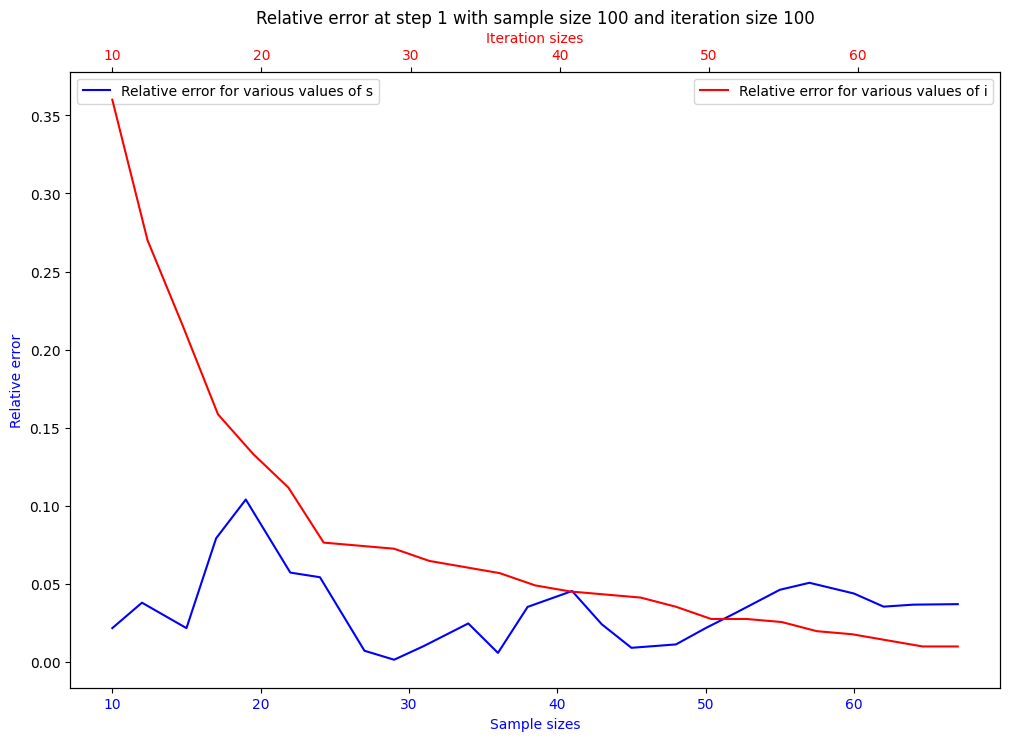

Iteration 1: s = 100, i = 100, area = 1.5330000000000004 (time taken: 0.76s))
Iteration curve is higher by -0.04670996755992061 on average
Percentage difference: 0.5787777260698219
Average difference: -0.04670996755992061


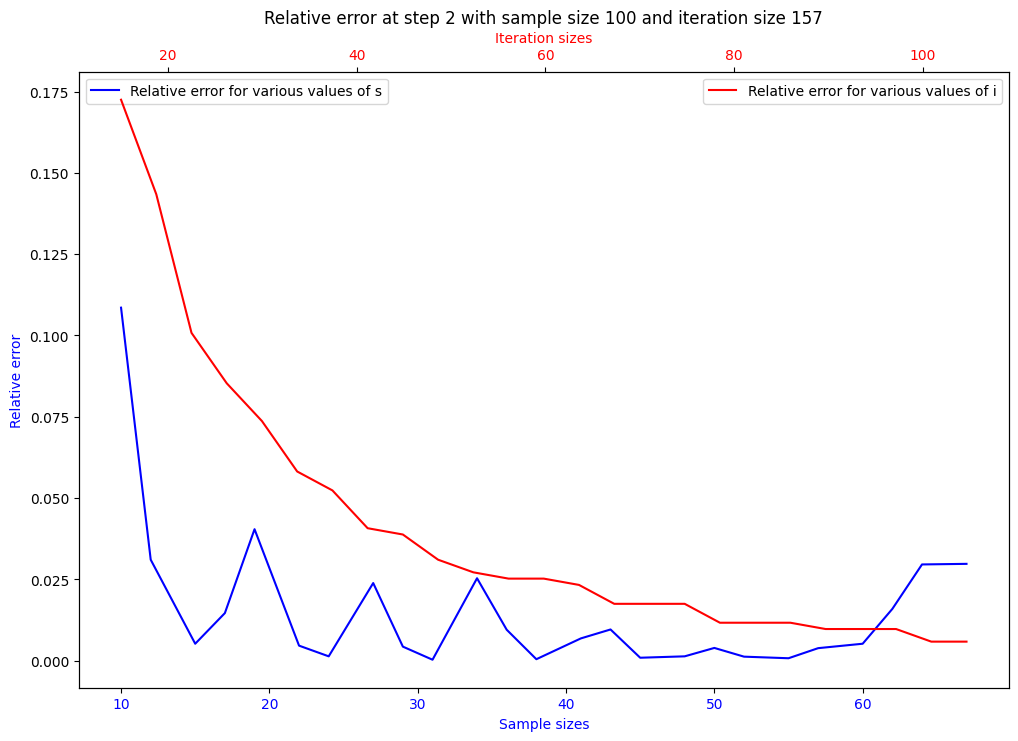

Iteration 2: s = 100, i = 157, area = 1.5479999999999998 (time taken: 0.79s))
Iteration curve is higher by -0.025906207654900322 on average
Percentage difference: 0.6317392792971894
Average difference: -0.025906207654900322


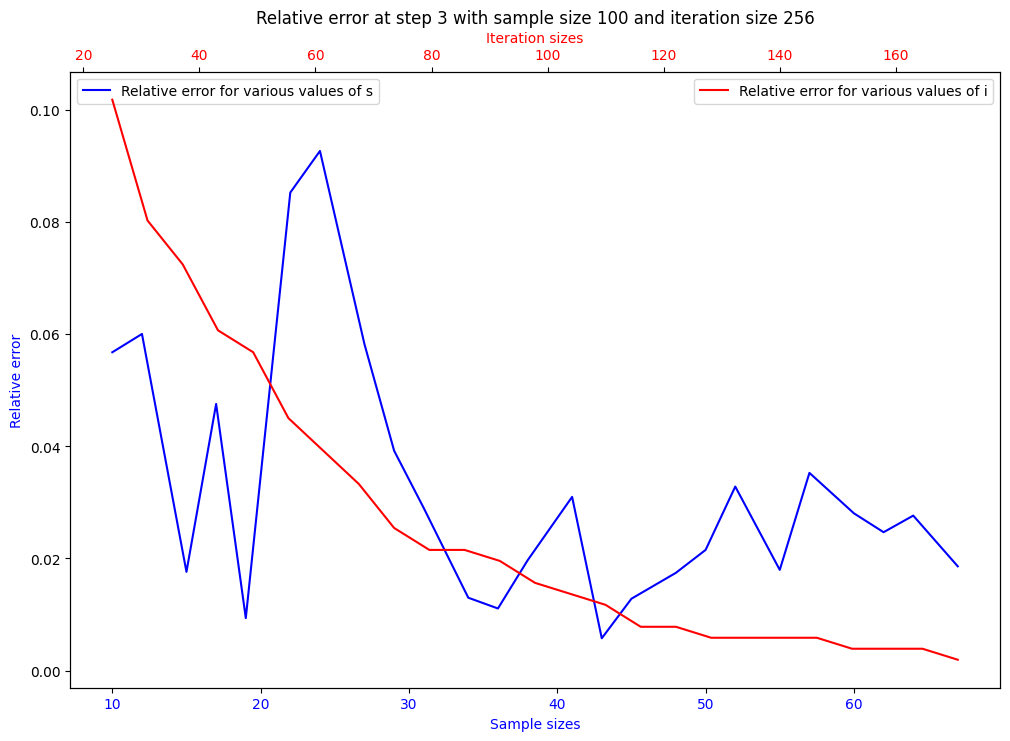

Iteration 3: s = 100, i = 256, area = 1.5330000000000006 (time taken: 1.0s))
Sample curve is higher by 0.005665702465873792 on average
Percentage difference: 0.1742487901132282
Average difference: 0.005665702465873792


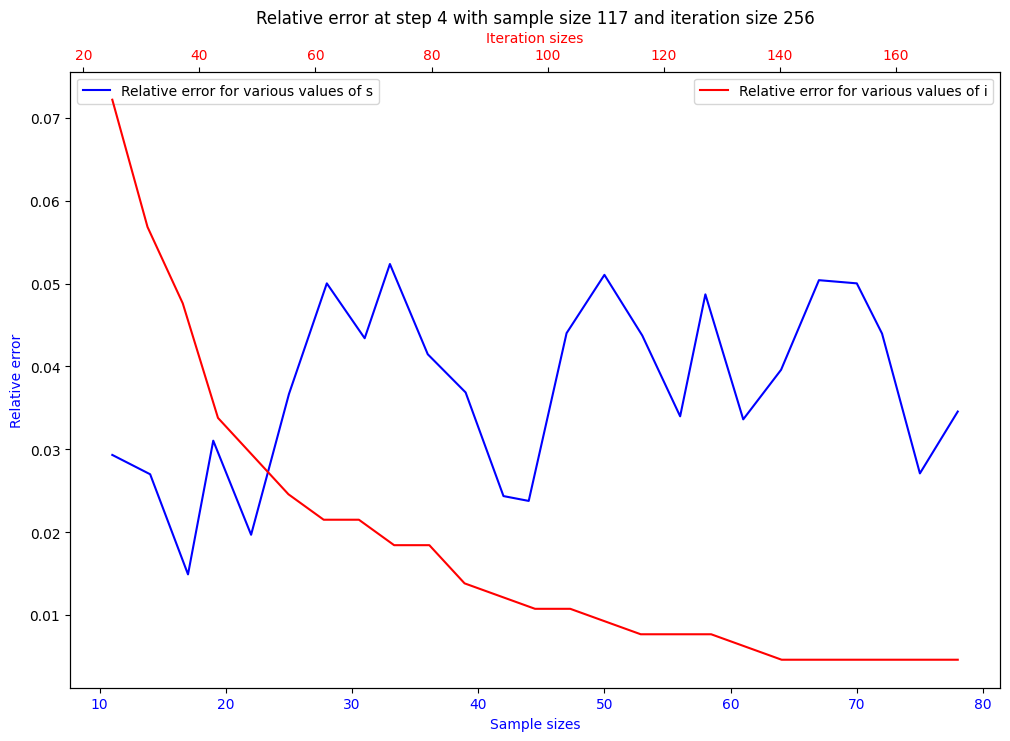

Iteration 4: s = 117, i = 256, area = 1.669230769230769 (time taken: 1.18s))
Sample curve is higher by 0.018959062060866613 on average
Percentage difference: 0.5087038026415505
Average difference: 0.018959062060866613


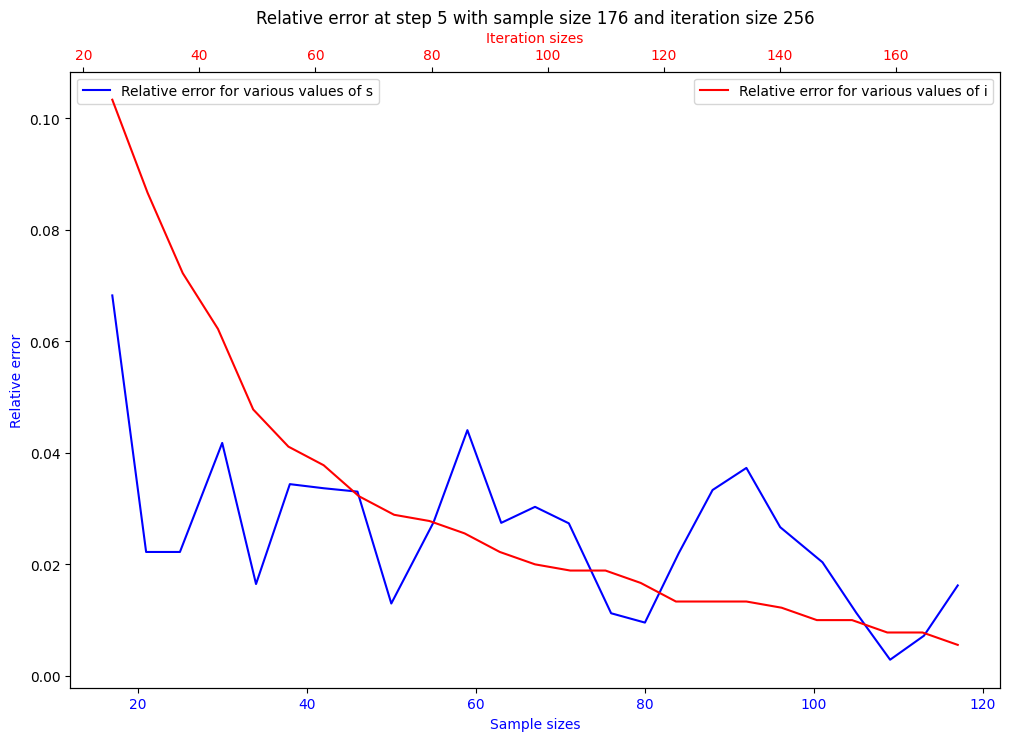

Iteration 5: s = 176, i = 256, area = 1.5340909090909087 (time taken: 1.64s))
Iteration curve is higher by -0.004630223324829567 on average
Percentage difference: 0.1532059188362719
Average difference: -0.004630223324829567


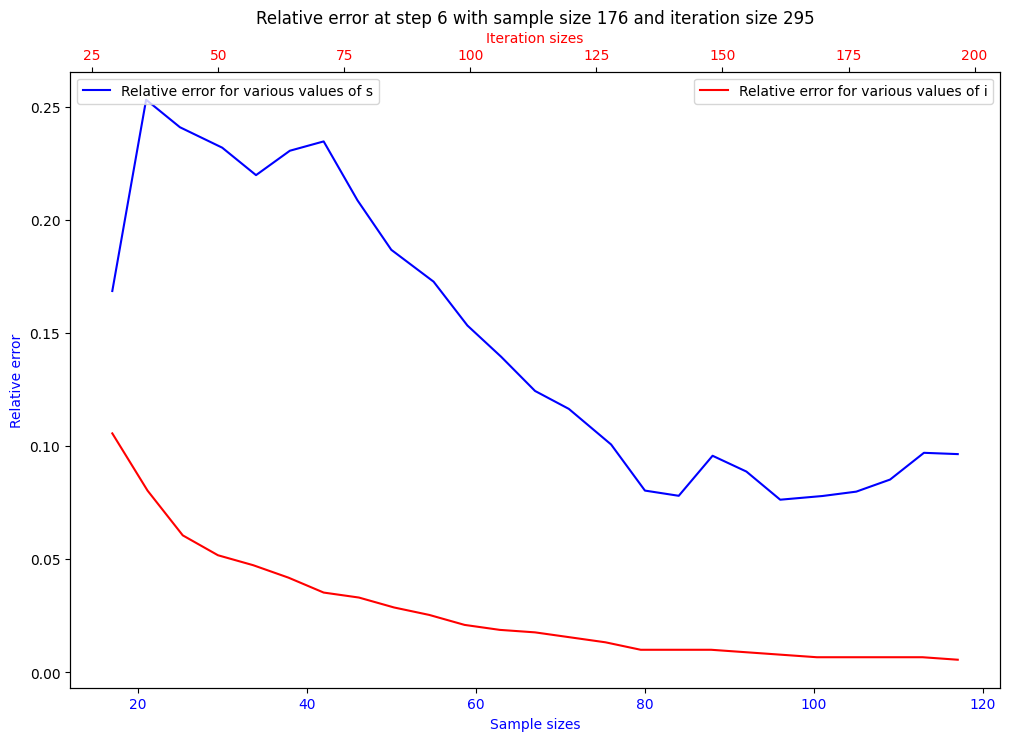

Iteration 6: s = 176, i = 295, area = 1.5494318181818187 (time taken: 1.67s))
Sample curve is higher by 0.11858412126454822 on average
Percentage difference: 0.8149281693922966
Average difference: 0.11858412126454822


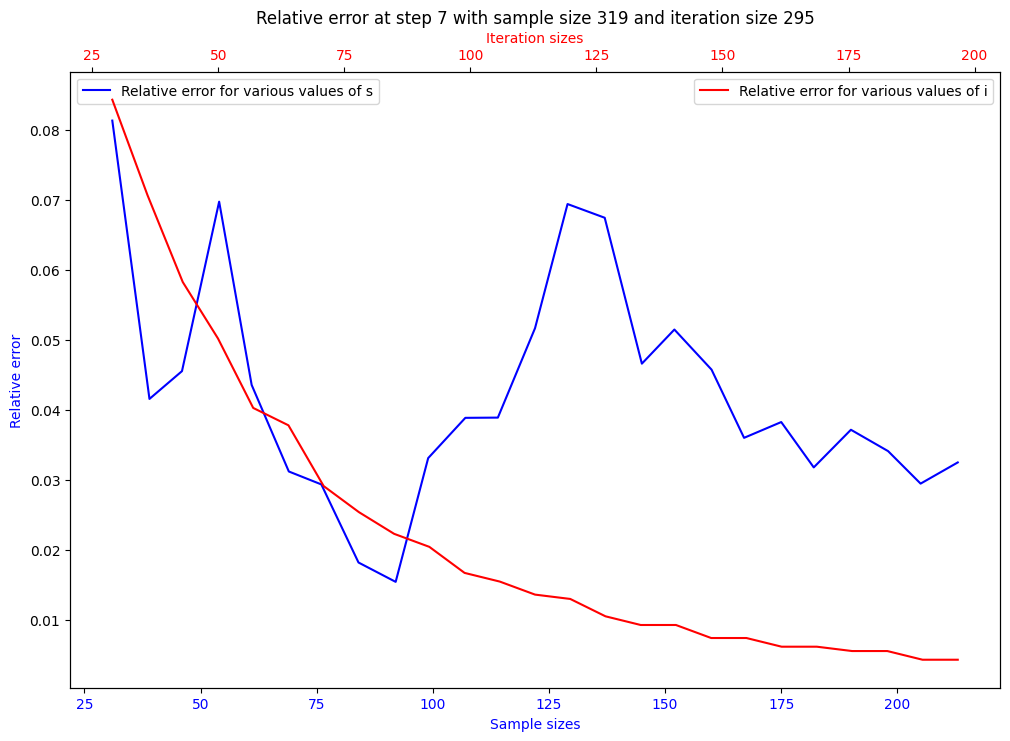

Iteration 7: s = 319, i = 295, area = 1.5169278996865203 (time taken: 2.89s))
Sample curve is higher by 0.019392629622013643 on average
Percentage difference: 0.45784790579503276
Average difference: 0.019392629622013643


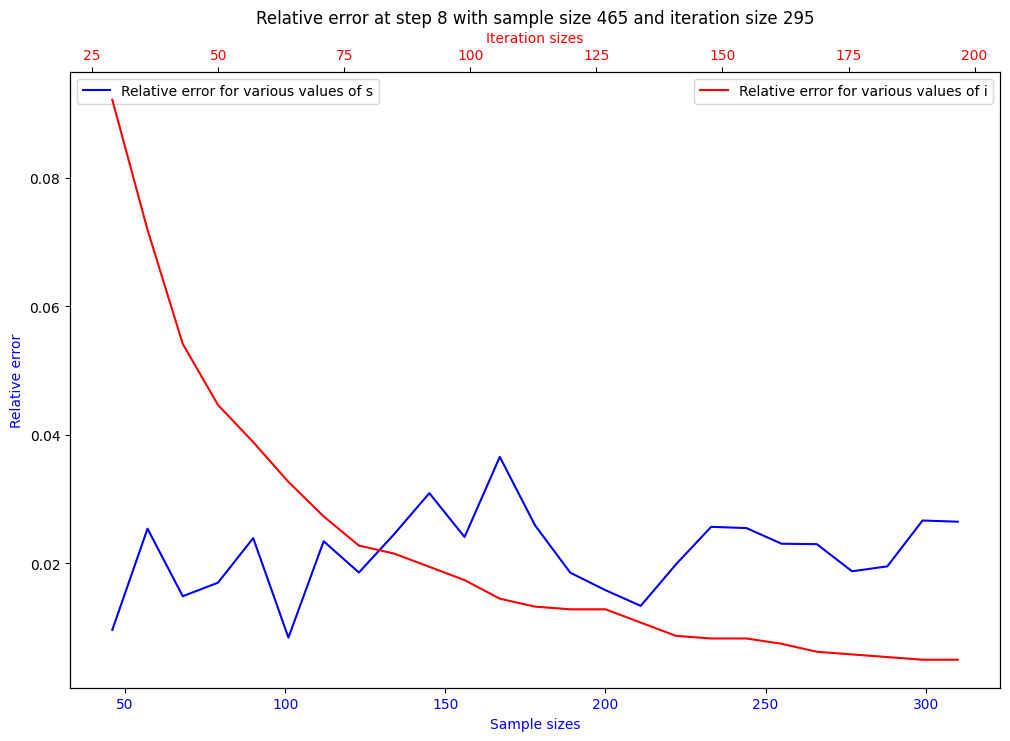

Iteration 8: s = 465, i = 295, area = 1.5606451612903223 (time taken: 4.15s))
Iteration curve is higher by -0.0011135400765023597 on average
Percentage difference: 0.049118407094441756
Average difference: -0.0011135400765023597


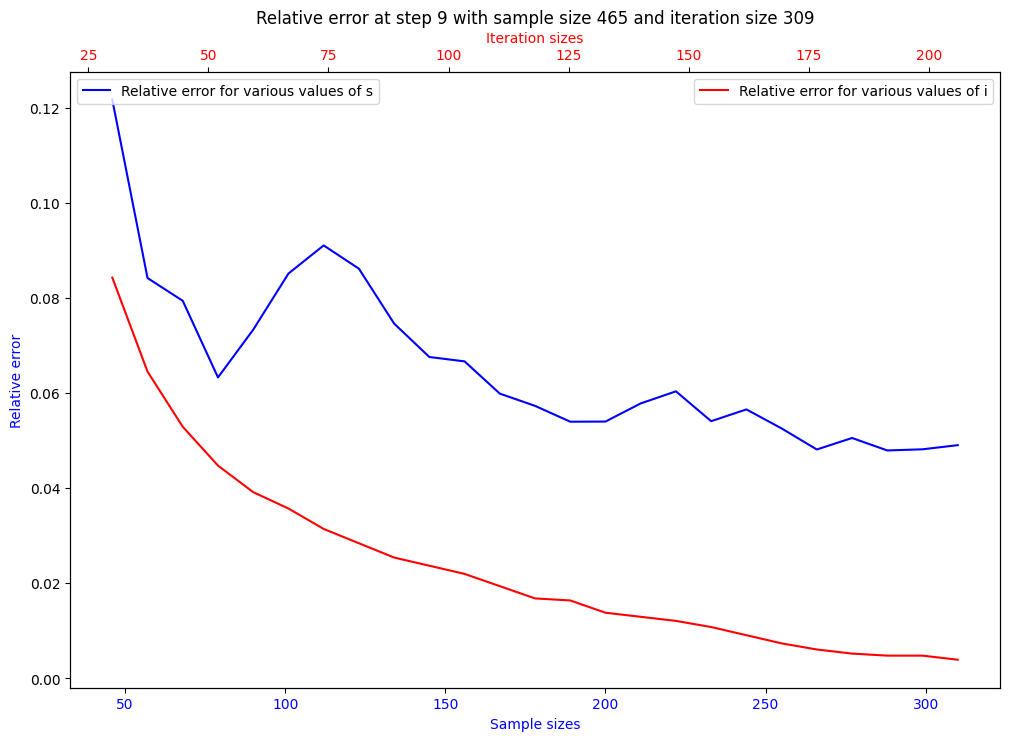

Iteration 9: s = 465, i = 309, area = 1.5000000000000002 (time taken: 4.28s))
Sample curve is higher by 0.04194851141480551 on average
Percentage difference: 0.6380772300291048
Average difference: 0.04194851141480551


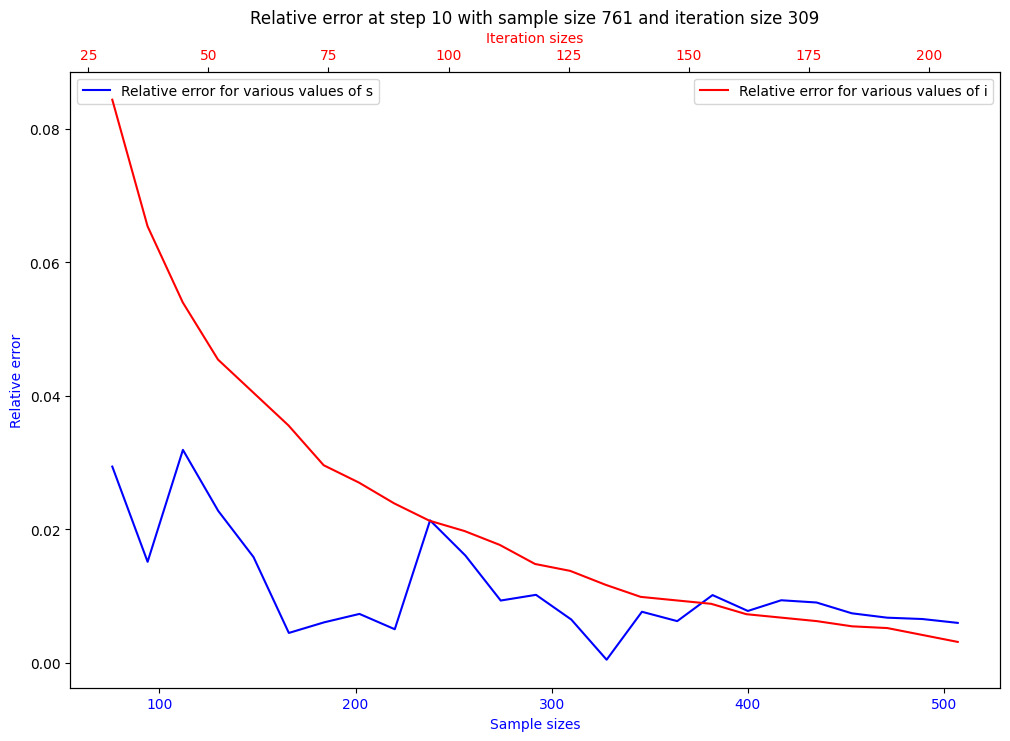

Iteration 10: s = 761, i = 309, area = 1.5185282522996058 (time taken: 6.76s))
Iteration curve is higher by -0.011697907708437991 on average
Percentage difference: 0.5122821793190458
Average difference: -0.011697907708437991


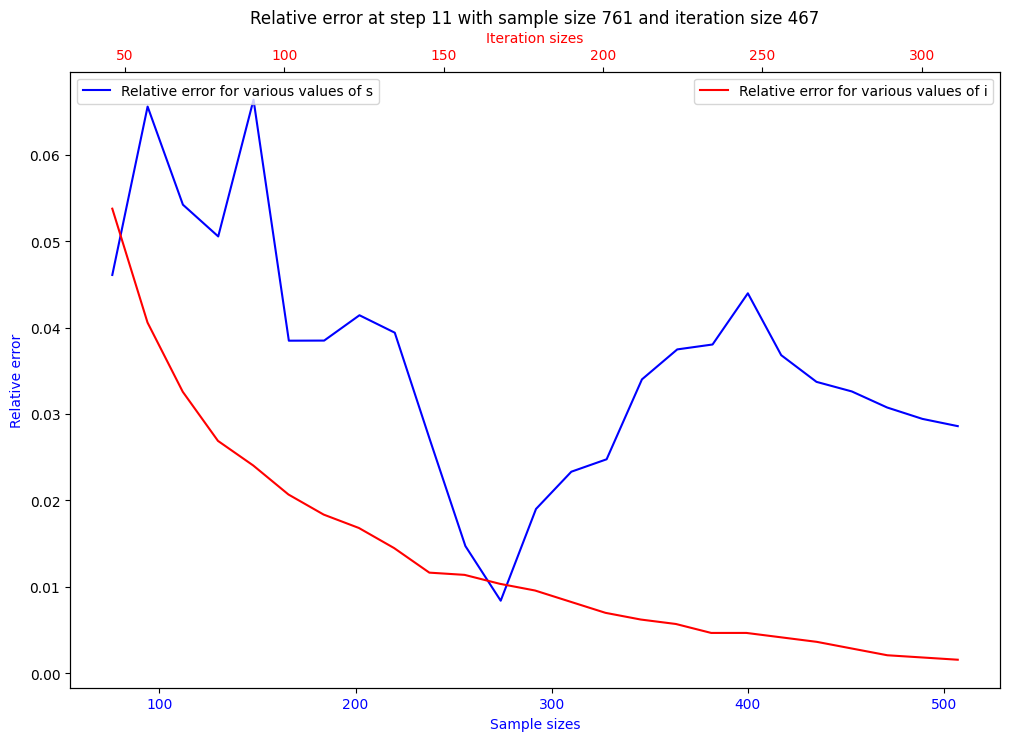

Iteration 11: s = 761, i = 467, area = 1.5244415243101186 (time taken: 9.23s))
Sample curve is higher by 0.022395183500862764 on average
Percentage difference: 0.6196395759226937
Average difference: 0.022395183500862764


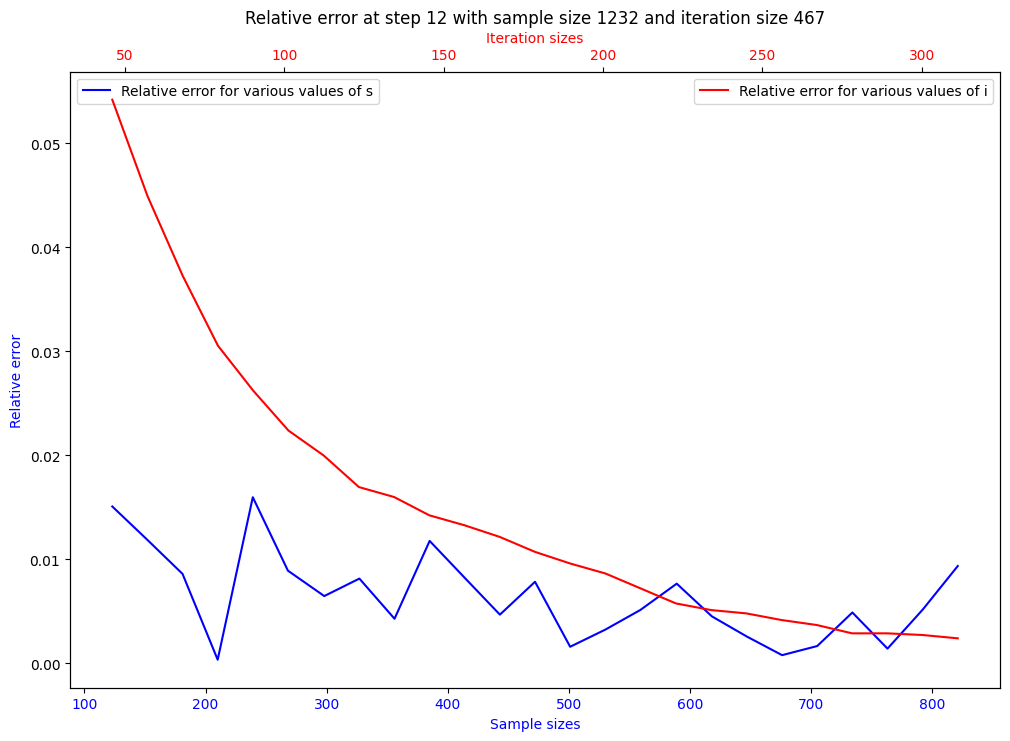

Iteration 12: s = 1232, i = 467, area = 1.523376623376623 (time taken: 14.68s))
Iteration curve is higher by -0.00874008349514455 on average
Percentage difference: 0.577258893007004
Average difference: -0.00874008349514455


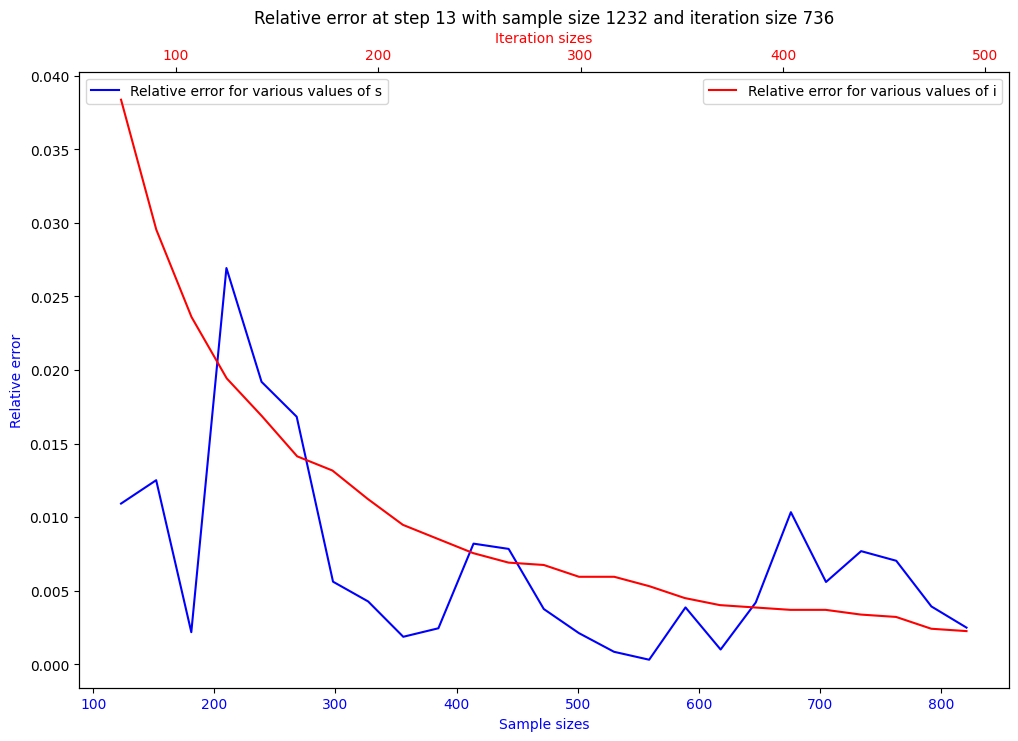

Iteration 13: s = 1232, i = 736, area = 1.5165584415584417 (time taken: 21.06s))
Iteration curve is higher by -0.00327362559077667 on average
Percentage difference: 0.3225971547366652
Average difference: -0.00327362559077667


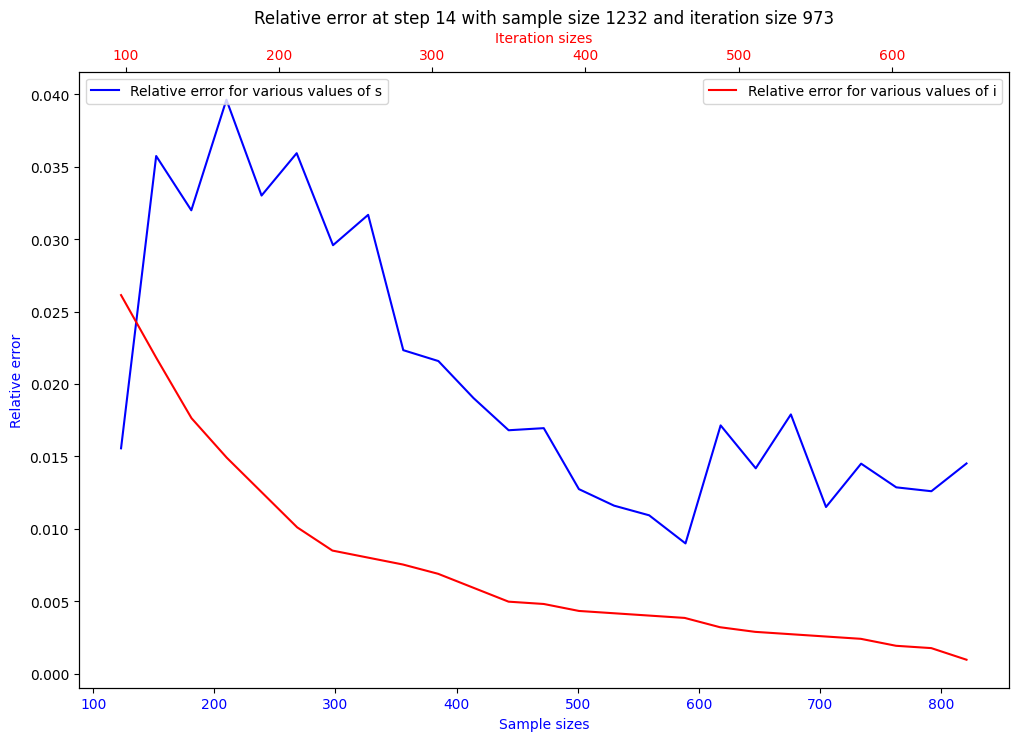

Iteration 14: s = 1232, i = 973, area = 1.5187500000000007 (time taken: 26.66s))
Sample curve is higher by 0.01298824319287119 on average
Percentage difference: 0.6376163452071094
Average difference: 0.01298824319287119


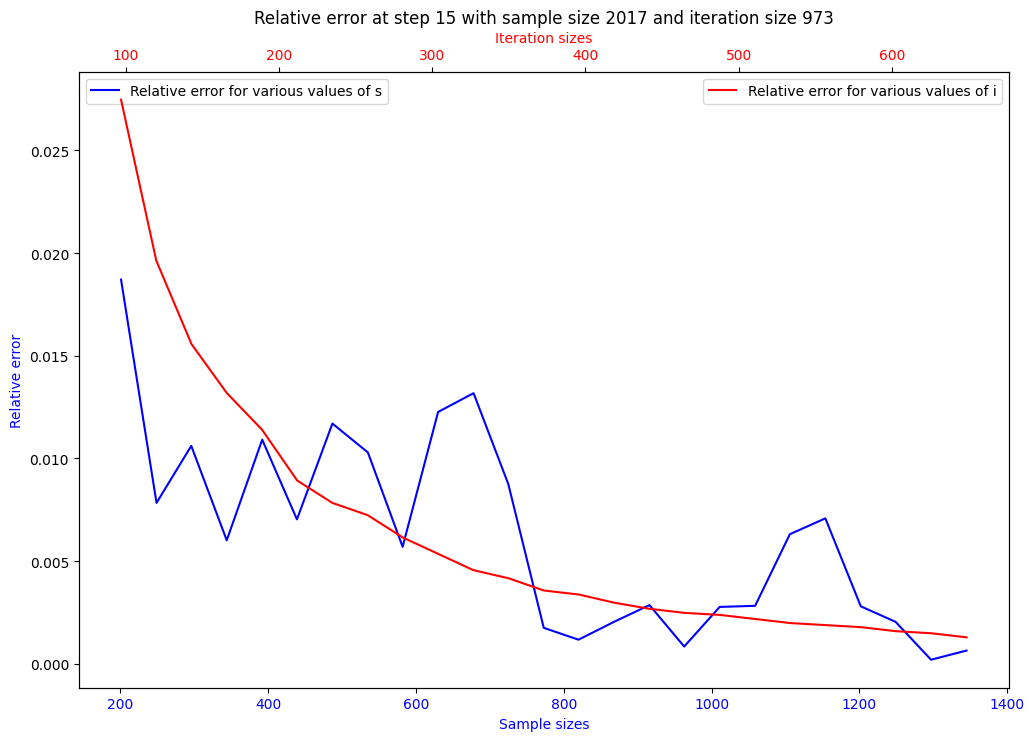

Iteration 15: s = 2017, i = 973, area = 1.499702528507685 (time taken: 43.35s))
Iteration curve is higher by -0.00019253185514384597 on average
Percentage difference: 0.029866133775622958
Average difference: -0.00019253185514384597


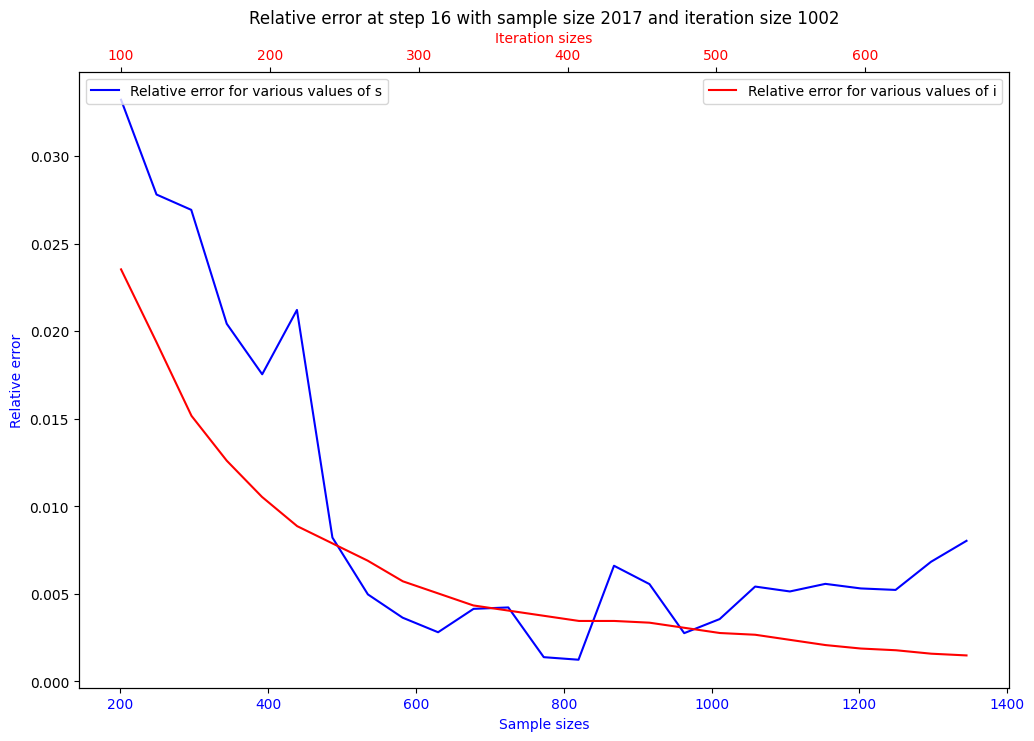

Iteration 16: s = 2017, i = 1002, area = 1.511006445215667 (time taken: 45.21s))
Sample curve is higher by 0.003203554260343758 on average
Percentage difference: 0.3370960571174659
Average difference: 0.003203554260343758


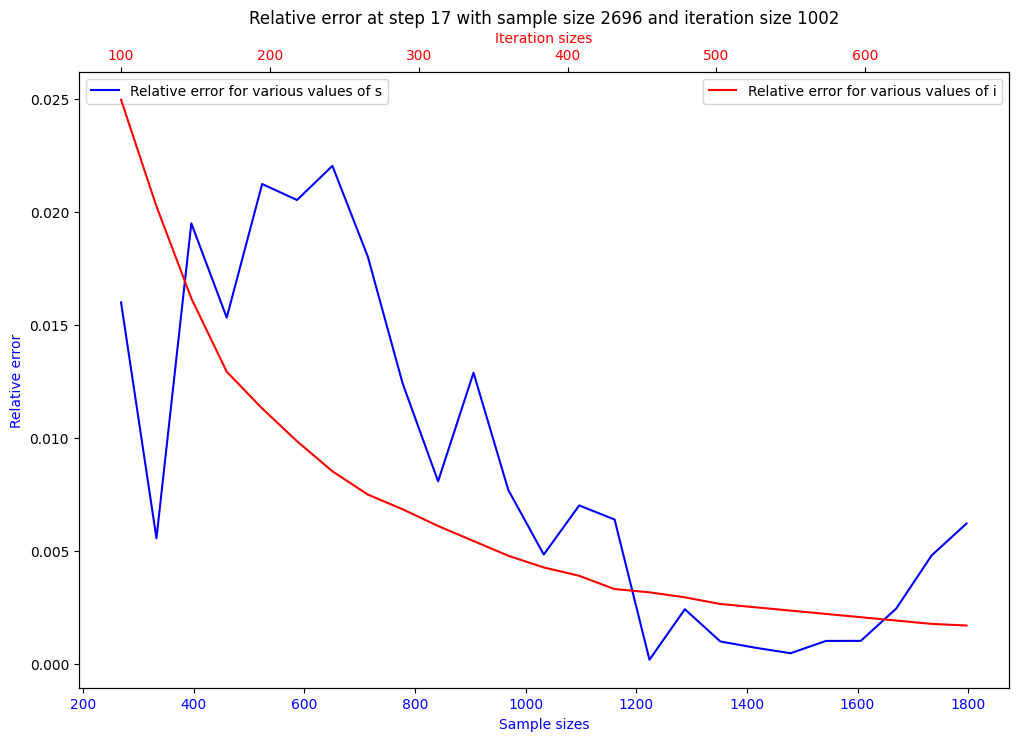

Iteration 17: s = 2696, i = 1002, area = 1.5159124629080123 (time taken: 59.69s))
Sample curve is higher by 0.0019337547369966727 on average
Percentage difference: 0.22222670765780764
Average difference: 0.0019337547369966727


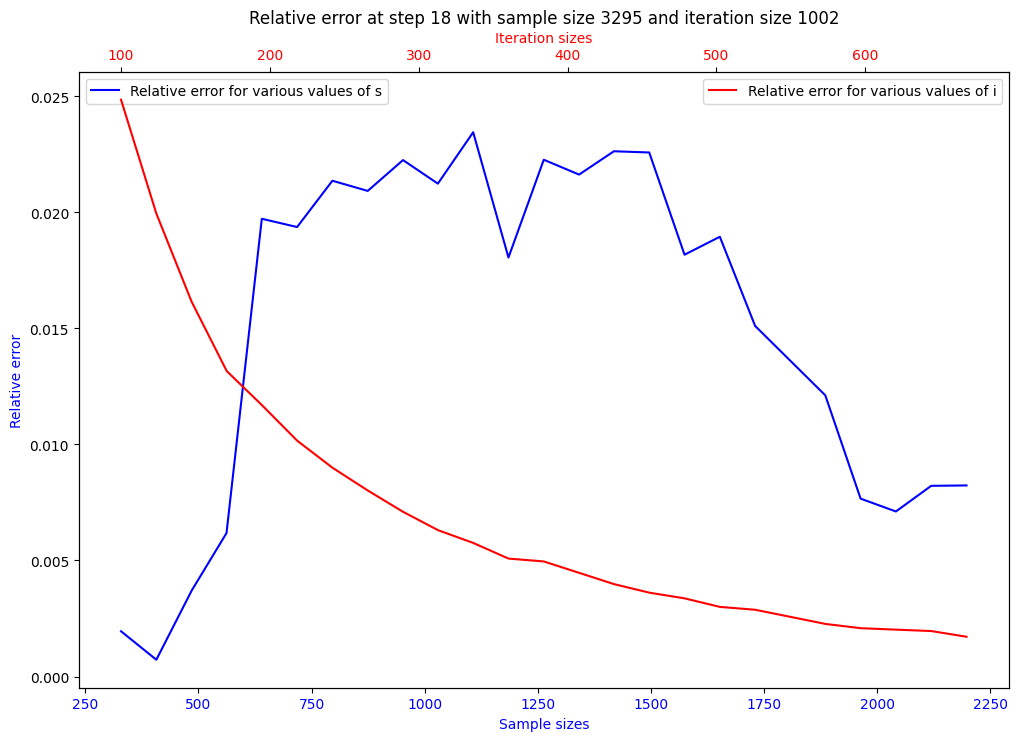

Iteration 18: s = 3295, i = 1002, area = 1.4870713201820942 (time taken: 71.99s))
Sample curve is higher by 0.008045122657821247 on average
Percentage difference: 0.5331080065811791
Average difference: 0.008045122657821247


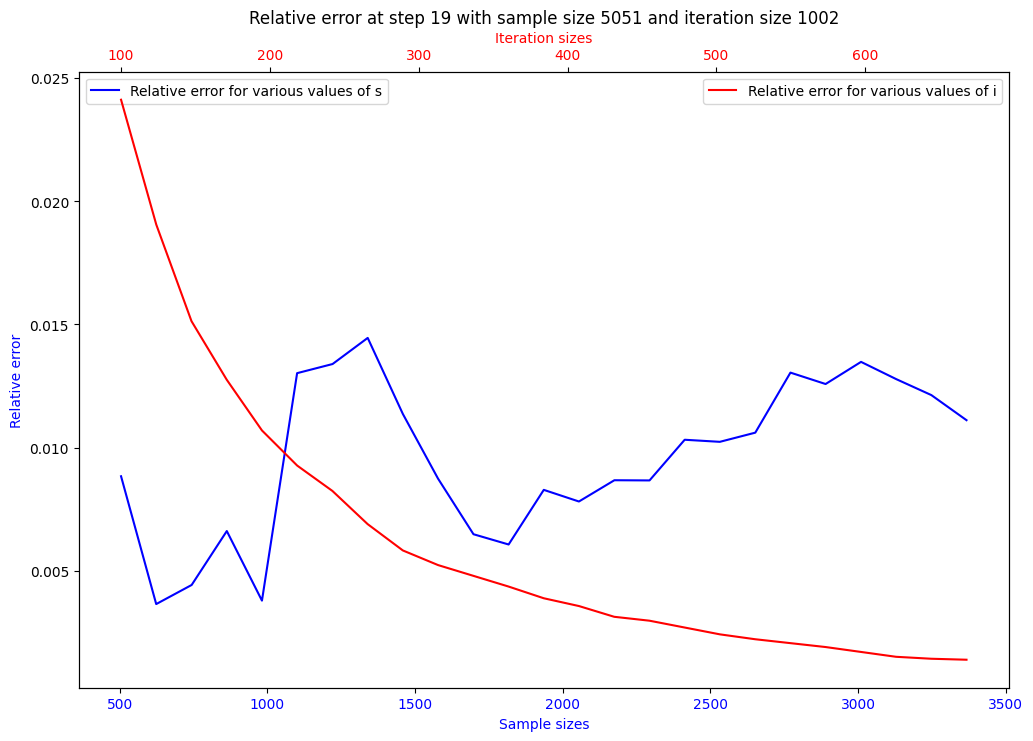

Iteration 19: s = 5051, i = 1002, area = 1.499821817461889 (time taken: 112.92s))
Sample curve is higher by 0.00333166085304247 on average
Percentage difference: 0.346373744897058
Average difference: 0.00333166085304247


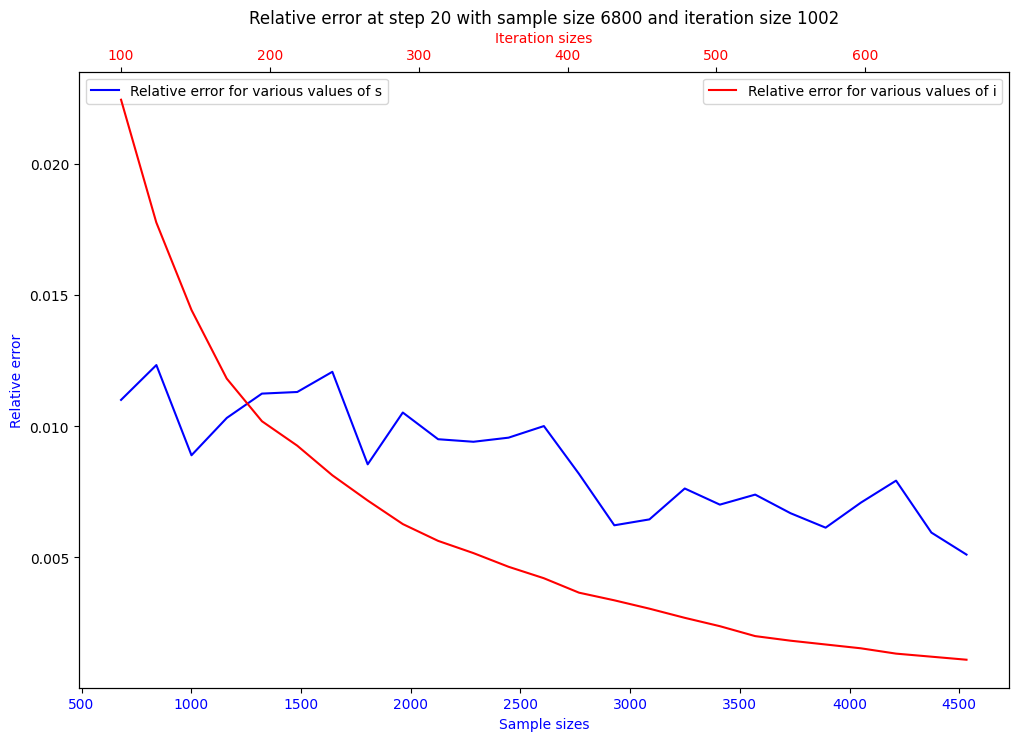

Iteration 20: s = 6800, i = 1002, area = 1.5198088235294118 (time taken: 151.56s))
Sample curve is higher by 0.002540273220252456 on average
Percentage difference: 0.29335224989210956
Average difference: 0.002540273220252456


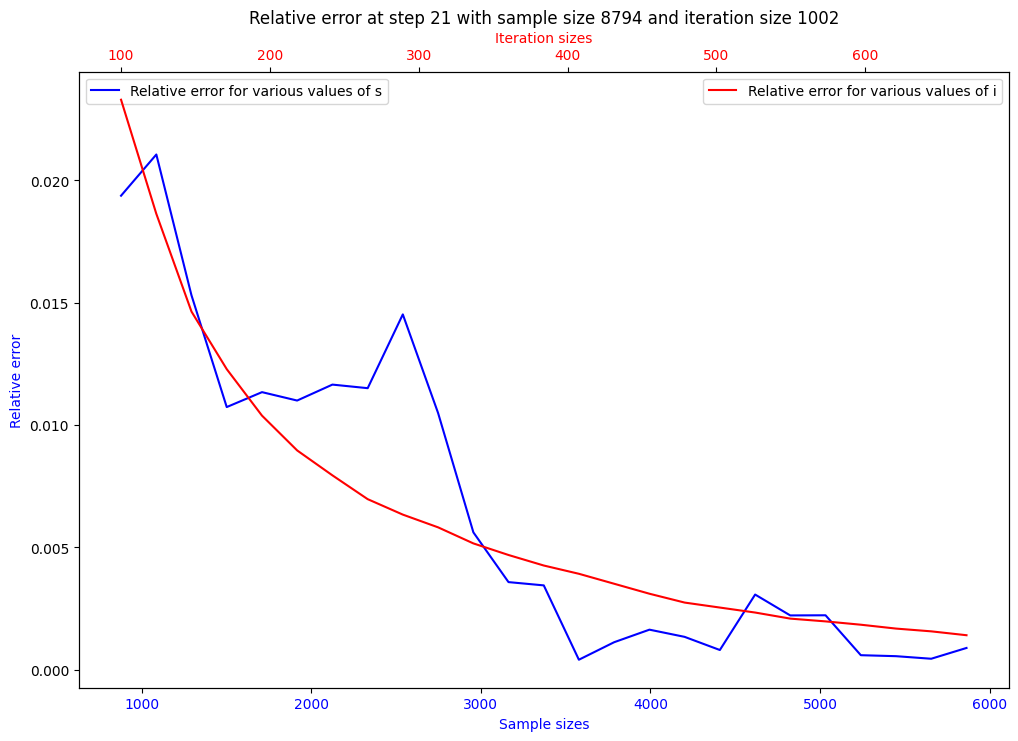

Iteration 21: s = 8794, i = 1002, area = 1.5079827154878325 (time taken: 194.68s))
Sample curve is higher by 0.00027393612336417604 on average
Percentage difference: 0.041544964951508084
Average difference: 0.00027393612336417604


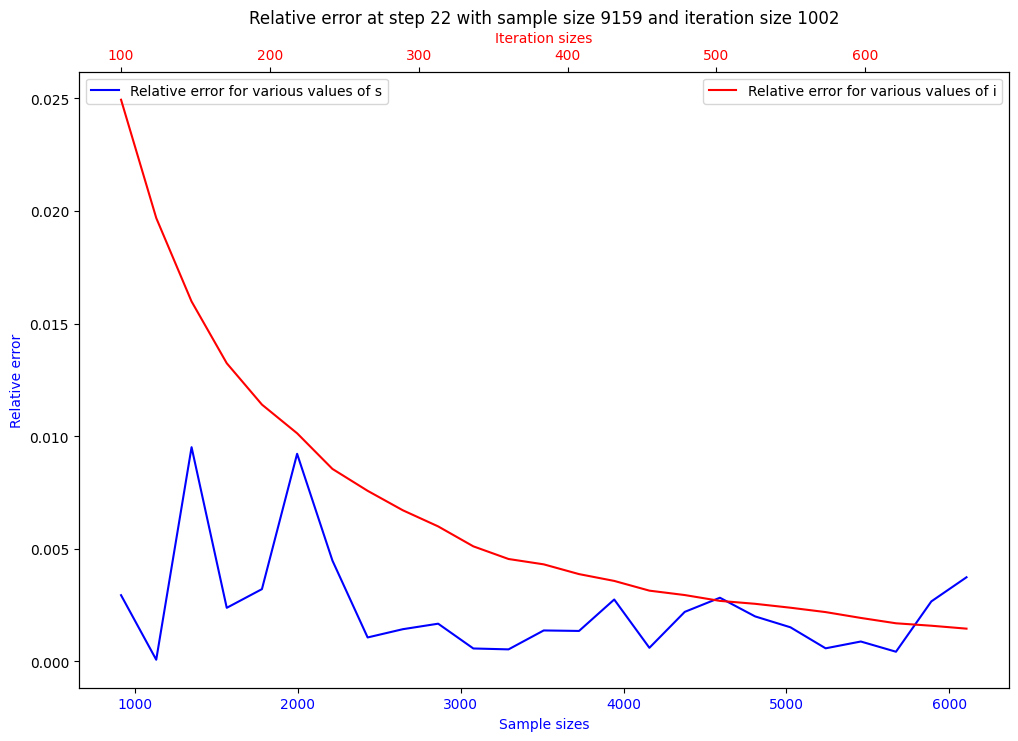

Iteration 22: s = 9159, i = 1002, area = 1.5139534883720929 (time taken: 201.66s))
Iteration curve is higher by -0.004329691991286287 on average
Percentage difference: 0.6438125515674971
Average difference: -0.004329691991286287


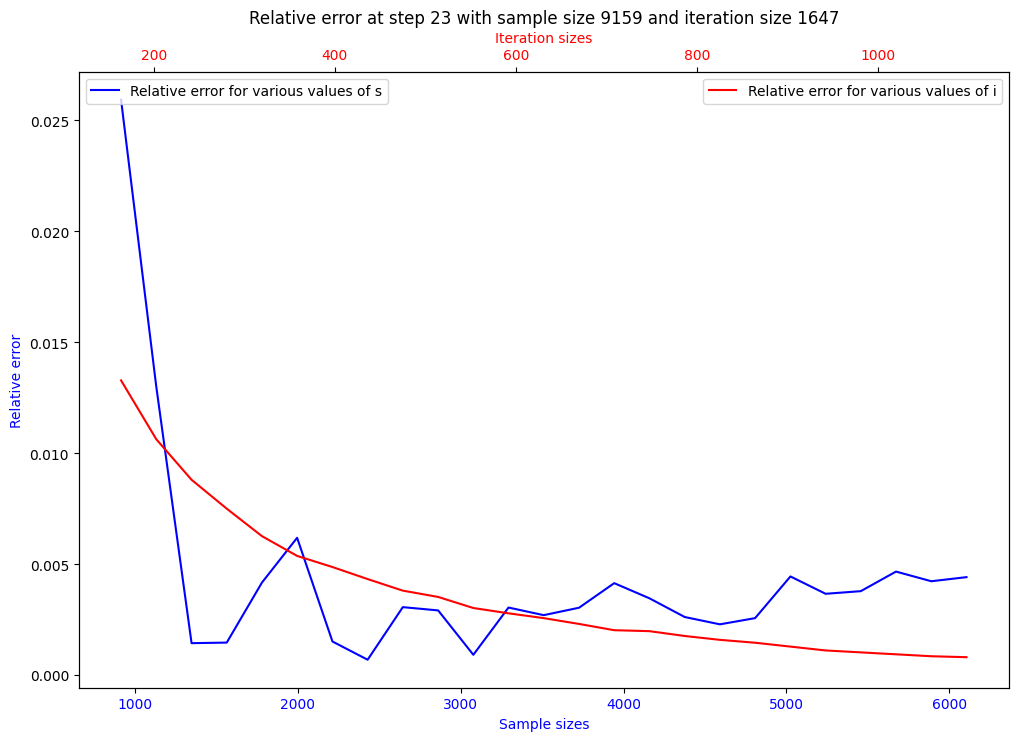

Iteration 23: s = 9159, i = 1647, area = 1.5066164428431057 (time taken: 318.09s))
Sample curve is higher by 0.0006597508121017282 on average
Percentage difference: 0.1494708790199989
Average difference: 0.0006597508121017282


In [14]:
def exp_function(x, a, b):
    return a**x + b
# Find a value of s and i such that the relative error for both follows the same trend
# initial values:
s = 100
i = 100
min_s = int(s/10)
min_i = int(i/10)

n = 30

visualize = True
iteration = 0

# A dataframe to store the results, keeping track of the iteration, s, i, which curve is higher, and by how much
results = pd.DataFrame(columns=['s', 'i', 'avg_diff', 'time_taken', 'area'])

while True:
    iteration += 1
    start = time.time()
    # n samples so areas are averaged

    n_samples = [random_sampling(s) for _ in range(n)]
    area = sum([approximation(sample, i) for sample in n_samples]) / n

    s_values = np.round(np.linspace(min_s, s * 2/3, 25))
    i_values = np.linspace(min_i, i * 2/3, 25)

    # First we create the curve for various values of s
    samples = [[random_sampling(int(s_values[0])) for _ in range(n)]]
    for s_value in s_values[1:]:
        samples.append([additional_random_sampling(samples[-1][j], int(s_value)) for j in range(n)])
    # samples = [random_sampling(int(s_value)) for s_value in s_values]
    rel_error_sample = [abs(sum([approximation(sample[j], i) for j in range(n)]) / n - area) / area for sample in samples]

    # # Fit a curve to the data
    # params, covariance = opt.curve_fit(exp_function, s_values, rel_error_sample)
    # a_optimal, b_optimal = params
    # fitted_values = exp_function(s_values, a_optimal, b_optimal)

    # Then we create the curve for various values of i
    rel_error_iter = [abs(sum([approximation(n_samples[j], int(i_value)) for j in range(n)]) / n - area) / area for i_value in i_values]



    # Plot the curves together
    if visualize:
        fig, ax1 = plt.subplots(figsize=(12, 8))

        ax1.plot(s_values, rel_error_sample, color='blue', label='Relative error for various values of s')
        # ax1.plot(s_values, fitted_values, color='blue', linestyle='dashed', label='Fitted curve')
        ax1.set_xlabel('Sample sizes', color='blue')
        ax1.set_ylabel('Relative error', color='blue')
        ax1.tick_params(axis='x', labelcolor='blue')
        ax1.legend(loc='upper left')

        ax2 = ax1.twiny()
        ax2.plot(i_values, rel_error_iter, color='red', label='Relative error for various values of i')
        ax2.set_xlabel('Iteration sizes', color='red')
        ax2.tick_params(axis='x', labelcolor='red')
        ax2.legend(loc='upper right')

        plt.title(f"Relative error at step {iteration} with sample size {s} and iteration size {i}")
        plt.show()
    
    time_taken = time.time() - start
    print(f"Iteration {iteration}: s = {s}, i = {i}, area = {area} (time taken: {round(time_taken, 2)}s))")
    
    # Find which curve is higher and by how much
    diff = [rel_error_sample[i] - rel_error_iter[i] for i in range(len(rel_error_sample))]
    avg_diff = sum(diff) / len(diff)
    if sum(diff) > 0:
        # The sample curve is higher; we need to increase sample size
        percentage_diff = sum(diff) / sum(rel_error_sample)
        print(f"Sample curve is higher by {avg_diff} on average")
        print(f"Percentage difference: {percentage_diff}")
        s = int(s * (1 + percentage_diff))
        min_s = int(s / 10)
    else:
        # The iteration curve is higher; we need to increase iteration size
        percentage_diff = -sum(diff) / sum(rel_error_iter)
        print(f"Iteration curve is higher by {avg_diff} on average")
        print(f"Percentage difference: {percentage_diff}")
        i = int(i * (1 + percentage_diff))
        min_i = int(i / 10)
    
    print(f"Average difference: {sum(diff) / len(diff)}")

    # Store the results
    results.loc[iteration] = {'s': s, 'i': i, 'avg_diff': avg_diff, 'time_taken': time_taken, 'area': area}

    # Save the results to a csv file
    results.to_csv('results.csv')

    if iteration >= 50 or time_taken > 5*60:
        break




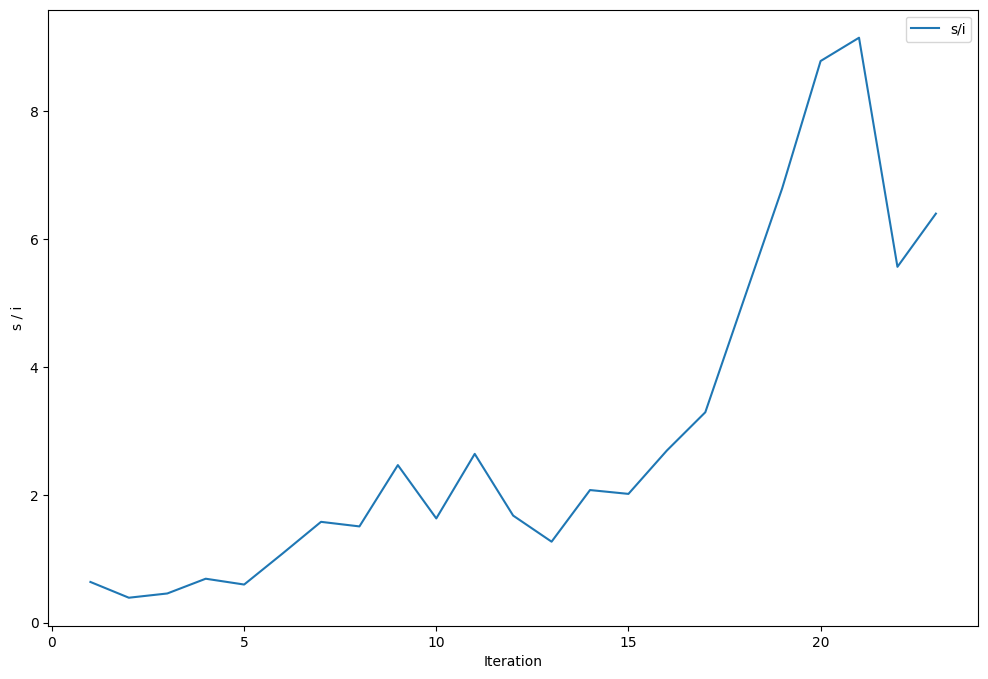

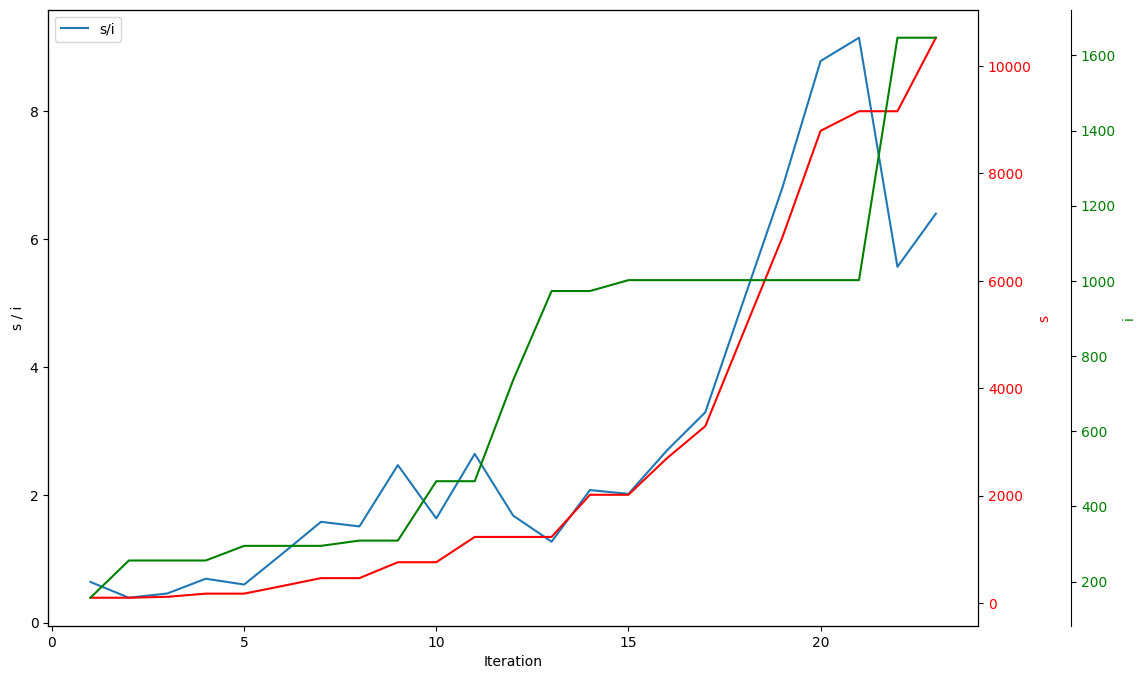

In [18]:
# plot s / i at every step
plt.figure(figsize=(12, 8))
plt.plot(results.index, results['s'] / results['i'], label='s/i')

plt.xlabel('Iteration')
plt.ylabel('s / i')
plt.legend()
plt.show()

# plot s/i and s and i at every step (3 y axes, with offset axes)
fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.plot(results.index, results['s'] / results['i'], label='s/i')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('s / i')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(results.index, results['s'], color='red', label='s')
ax2.set_ylabel('s', color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax3 = ax1.twinx()
ax3.plot(results.index, results['i'], color='green', label='i')
ax3.set_ylabel('i', color='green')
ax3.tick_params(axis='y', labelcolor='green')
ax3.spines.right.set_position(("axes", 1.1))

plt.show()

<Axes: >

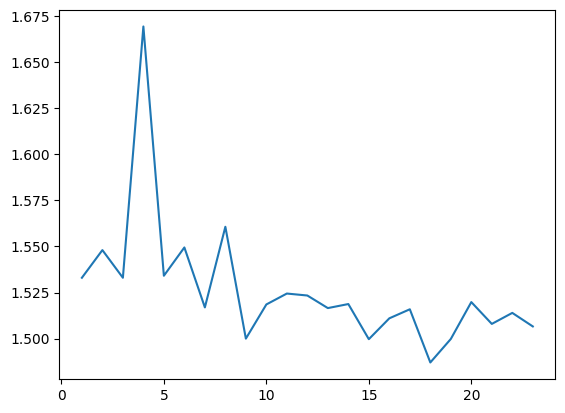

In [21]:
results['area'].plot()